<h1><b>CUSTOMER CHURN DETECTION </b> </h1>
Gadda A.,<br>
Università degli Studi di Milano Bicocca <br><br><br>

## Load Libraries
(Output: 330586 rows, 103 columns)

In [ ]:
#Update Sklearn version to 1.2.1 to allow for .set_output method to be used.
!pip uninstall scikit-learn -y
!pip install -U scikit-learn

#Load libraries.
import pandas as pd
import numpy as np
from google.colab import drive
from shutil import copyfile
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from keras import datasets, layers, models
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from imblearn.over_sampling import RandomOverSampler, SMOTE, SMOTEN, SMOTENC, SVMSMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from keras import regularizers

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
!pip install shap
import shap


import random
from numpy.random import seed
sd = 444
seed(sd)
tf.random.set_seed(sd)
random.seed(sd)

Found existing installation: scikit-learn 1.2.2
Uninstalling scikit-learn-1.2.2:
  Successfully uninstalled scikit-learn-1.2.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 38.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 11.3 MB/s eta 0:00:00


## Data Ingestion
(Output: 330586 rows, 103 columns)

In [ ]:
#Connect to the source of the dataset and load it.
drive.mount('/content/gdrive')
copyfile('gdrive/My Drive/ChurnDetection/dataset.csv', 'dataset.csv')
df = pd.read_csv("dataset.csv")

Mounted at /content/gdrive


## Training set selection
(Output train: 264468 rows, 104 columns)

In [ ]:
#Create key for stratified sampling (year + month + is_churner).
df['Sampling_KEY'] = df.DATA_RIF.str[:8] + df.Pdisc.astype(str)

#Divide training and test set.
train, test = train_test_split(df, test_size=0.20, stratify=df.Sampling_KEY, random_state=123)

## EDA & data preprocessing
(Output train: 264464 rows, 71 columns)

In [ ]:
a = train.columns

In [ ]:
s = set(a)
print([x for x in s if x not in train.columns])

[]


In [ ]:
#Drop useless columns.
train.drop(columns=['Unnamed: 0','Sampling_KEY'], inplace=True)

#Drop constant columns.
train = train.loc[:,train.apply(pd.Series.nunique) != 1]

#All colums have the correct data type.
[_ for _ in train.dtypes]

#Create month column (the year is always the same, i.e. 2017).
train.DATA_RIF.str[:4].nunique()
train['Month_NUM'] = train.DATA_RIF.str[5:7].astype(int)


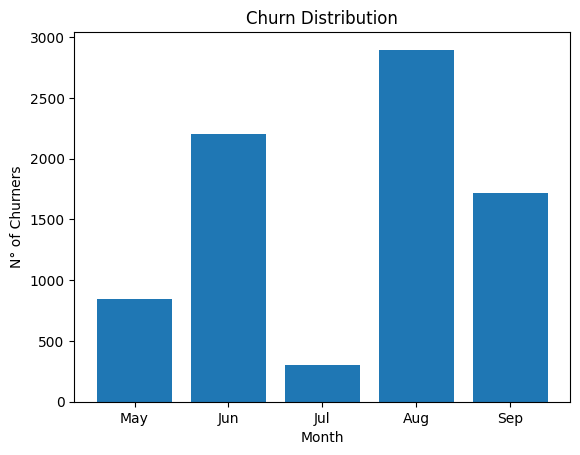

In [ ]:
#There are 7961 churners (3.01% over total), unevenly distributed across each months.
month_dist = train.groupby('Month_NUM').Pdisc.sum().reset_index()
month_dist.Pdisc.sum()
fig = plt.figure()
fig.set_facecolor("w")
fig = plt.bar(month_dist.Month_NUM,month_dist.Pdisc)
plt.title('Churn Distribution')
plt.xlabel('Month')
plt.ylabel('N° of Churners')
# plt.rcParams.update({
#     "figure.facecolor":  (1, 0.0, 1, 1)})
plt.xticks([5,6,7,8,9], ["May", "Jun", "Jul", "Aug", "Sep"], rotation='horizontal')
plt.show()
del(month_dist)

In [ ]:
#Let us check whether any services disappeared or was introduced later on.
services = \
[
    'CINEMA'
    ,'CALCIO'
    ,'SPORT'
    ,'SKY_FAMIGLIA'
    ,'FLG_MV'
    ,'FLG_MYSKYHD'
    ,'FLG_HD'
    ,'FLG_MYSKY'
    ,'FLG_SKY_ON_DEMAND'
    ,'STB_HD'
    ,'STB_MYSKYHD'
    ,'STB_MYSKY'
    ,'STB_SD'
]

#Count total number of months in the dataset.
month_count = len(train.groupby(['Month_NUM'])['Month_NUM'].nunique())

#Select only the services not appearing in all months.
anomaly = [_ for _ in services if train.groupby([_])['Month_NUM'].nunique().min() < month_count]

#The value two disappears from all of these services in June.
[train.groupby([_])['Month_NUM'].nunique() for _ in anomaly]
[train.groupby(['Month_NUM'])[_].nunique() for _ in anomaly]
#Since the dataset is from May to September, the hypothesis is rejected.

#Add a column to keep track of the number of services owned per user.
train['n_services'] = train.loc[:,services].astype(bool).sum(axis=1)

#Avoided to use the sum because five records are non-boolean with respect to some services.
train.loc[(train.CALCIO > 1) | (train.CINEMA > 1) | (train.SPORT > 1) | (train.SKY_FAMIGLIA > 1)]
del(month_count, anomaly)

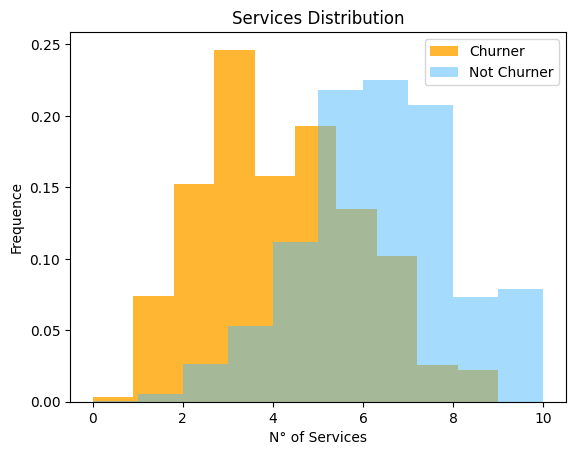

In [ ]:
plt.hist(train[train['Pdisc']==1]['n_services'], density=True, bins=10, alpha=0.8, label='Churner', color="orange")
plt.hist(train[train['Pdisc']==0]['n_services'], density=True, bins=10, alpha=0.5, label='Not Churner', color="#4DB9FB")
plt.legend()
plt.xlabel('N° of Services')
plt.ylabel('Frequence')
plt.title("Services Distribution")
plt.show()


In [ ]:
print(f"Mean services of churner: \t{np.mean(train[train['Pdisc']==1]['n_services'])}")
print(f"Mean services of not churner: \t{np.mean(train[train['Pdisc']==0]['n_services'])}")

Mean services of churner: 	4.176736590880543
Mean services of not churner: 	5.852035227108812


In [ ]:
sum(train[(train['n_services']==0)]['Pdisc'])/len(train[train['n_services']==0])

0.11458333333333333

In [ ]:
sum(train[(train['n_services']!=0)]['Pdisc'])/len(train[train['n_services']!=0])

0.030040563653150495

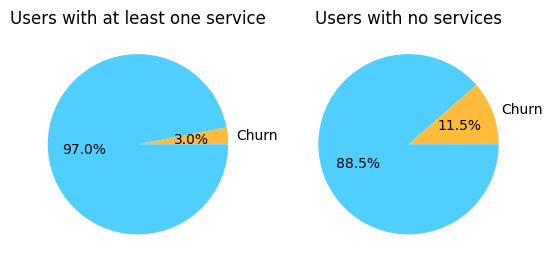

In [ ]:
probabilita_a = [0.03, 1-0.03]  # Probabilità per il primo pie plot
probabilita_b = [0.1146, 1-0.1146]  # Probabilità per il secondo pie plot

# Etichette per le due classi
etichette = ['Churn', '']

plt.subplot(1, 2, 1)  # Primo pie plot
plt.pie(probabilita_a, labels=etichette, colors=['#FFBB3B','#50CFFF'], autopct='%1.1f%%')
plt.title('Users with at least one service')

# Creazione del grafico a torta con le probabilità della Classe B
plt.subplot(1, 2, 2)  # Secondo pie plot
plt.pie(probabilita_b, labels=etichette, colors=['#FFBB3B','#50CFFF'], autopct='%1.1f%%')
plt.title('Users with no services')

plt.show()

In [ ]:
#There are 2736 duplicated IDs (1.03% over total).
sum(train.duplicated(subset=['external_id']))

#There are 4 rows to delete because they are entirely duplicated.
sum(train.duplicated())
train.drop_duplicates(inplace=True)

#All duplicates have the same DATA_RIF.
dups = train[train.duplicated(subset=['external_id'],keep=False)].sort_values('external_id')
(dups.groupby(['external_id']).nunique(['DATA_RIF']).DATA_RIF > 1).any()
train.drop('DATA_RIF', axis=1, inplace=True)

#The columns having different values in at least one pair of duplicated records only involve the type of service used (each one of them).
dups_range = dups.groupby('external_id').agg(np.ptp).reset_index()
dups_change = dups_range.loc[:,dups_range.apply(pd.Series.nunique) != 1]
dups_change.columns
#Among these duplicate records, there is no way of telling which ones are correct (maybe all of them, maybe none).

#Temporarily set aside duplicate records to analyse if they affect churn rate.
no_dups = train.loc[~train.index.isin(dups.index)]

#Churn incidence in duplicate rows is 6.3%, more than double the incidence in non-duplicate rows (3.0%).
dups_churn = dups.Pdisc.value_counts()
no_dups_churn = no_dups.Pdisc.value_counts()
round(dups_churn[1] / dups_churn[0] - no_dups_churn[1] / no_dups_churn[0], 3)

#Despite not being able to tell if the data is correct in the first place, we can capture this apparently-useful information in a new variable.
train['Modified'] = 0
train.loc[dups.index,'Modified'] = 1

#Drop the row ID.
train.drop(columns=['external_id'], inplace=True)
del(dups, dups_range, dups_change, no_dups, dups_churn, no_dups_churn)

['DATA_RIF'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.


In [ ]:
col_time=train.columns[13:20]
col_length=train.columns[21:30]
col_category=train.columns[30:55]

In [ ]:
#Check if time and lenght columns sum is 1
train[col_length].sum(axis=1).mean() #0.98
((train[col_length].sum(axis=1)==0).sum())/train.shape[0] #2% (coincide con i casi di n° di ok url = 0)
((train[col_length].sum(axis=1)>=0.99).sum())/train.shape[0] #98%

train[col_time].sum(axis=1).mean() #0.96
((train[col_time].sum(axis=1)==0).sum())/train.shape[0] #0.3%
((train[col_time].sum(axis=1)>=0.99).sum())/train.shape[0] #74%

#Check if category columns sum is 100
train[col_category].sum(axis=1).mean() #54
((train[col_category].sum(axis=1)==0).sum())/train.shape[0] #3.5%
((train[col_category].sum(axis=1)==100).sum())/train.shape[0] #2.4%

0.02415451630467663

In [ ]:
#Standardize all the features.
scaler = StandardScaler().set_output(transform="pandas")
#train = scaler.fit_transform(train)

#Separate the response variable from the covariates in case it is needed.
train_resp = train.loc[:, train.columns == 'Pdisc']
train_cov = train.loc[:, train.columns != 'Pdisc']
train_cov = scaler.fit_transform(train_cov)

In [ ]:
#Create the same columns also on the test set.
test['Month_NUM'] = test.DATA_RIF.str[6].astype(int)
test['n_services'] = test.loc[:,services].astype(bool).sum(axis=1)
dups = test[test.duplicated(subset=['external_id'],keep=False)].sort_values('external_id')
test['Modified'] = 0
test.loc[dups.index,'Modified'] = 1
test = test.loc[:, train.columns] #Ensure the same columns are being used.
#test = scaler.transform(test) #Do not fit, just transform with the training parameters.

#Separate the response variable from the covariates in case it is needed.
test_resp = test.loc[:, test.columns == 'Pdisc']
test_cov = test.loc[:, test.columns != 'Pdisc']
test_cov = scaler.transform(test_cov)
del(dups)

In [ ]:
train_cov

,how_many_ok_urls,how_many_ko_urls,os_android,os_ios,os_linux,os_other,os_windows,browser_chrome,browser_firefox,browser_opera,...,FLG_HD,FLG_MYSKY,FLG_SKY_ON_DEMAND,STB_HD,STB_MYSKYHD,STB_MYSKY,STB_SD,Month_NUM,n_services,Modified
324842,-0.307320,-0.189690,-0.069712,-0.038182,-0.015436,0.177321,-0.156659,-0.148245,-0.074147,-0.010827,...,-0.498033,-0.293897,0.395046,-0.325438,0.361144,-0.042149,-0.104522,1.330132,0.114101,-0.144566
297333,-0.412193,-0.189690,-0.069712,-0.038182,-0.015436,0.177321,-0.156659,-0.148245,-0.074147,-0.010827,...,-0.498033,-0.293897,0.395046,-0.325438,0.361144,-0.042149,-0.104522,-0.793544,0.114101,-0.144566
38649,1.921220,-0.224181,-0.069712,-0.038182,-0.015436,0.177321,-0.156659,-0.148245,-0.074147,-0.010827,...,2.007899,-0.293897,0.395046,3.072780,-2.768981,-0.042149,-0.104522,1.330132,-0.461134,-0.144566
42932,-0.025476,-0.224181,-0.069712,-0.038182,-0.015436,0.177321,-0.156659,-0.148245,-0.074147,-0.010827,...,-0.498033,3.402551,0.395046,-0.325438,0.361144,-0.042149,-0.104522,-0.085652,0.114101,-0.144566
181165,-0.320429,-0.224181,-0.069712,-0.038182,-0.015436,0.177321,-0.156659,-0.148245,-0.074147,-0.010827,...,-0.498033,-0.293897,0.395046,-0.325438,0.361144,-0.042149,-0.104522,-0.793544,0.114101,-0.144566
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51350,-0.077912,0.965765,-0.069712,-0.038182,-0.015436,0.177321,-0.156659,-0.148245,-0.074147,-0.010827,...,-0.498033,-0.293897,0.395046,-0.325438,0.361144,-0.042149,-0.104522,1.330132,0.114101,-0.144566
47862,-0.418747,0.310433,-0.069712,-0.038182,-0.015436,0.177321,-0.156659,-0.148245,-0.074147,-0.010827,...,-0.498033,-0.293897,-2.531353,-0.325438,0.361144,-0.042149,-0.104522,-0.793544,-0.461134,-0.144566
176641,-0.438411,-0.172444,-0.069712,-0.038182,-0.015436,0.177321,-0.156659,-0.148245,-0.074147,-0.010827,...,-0.498033,-0.293897,0.395046,-0.325438,0.361144,-0.042149,-0.104522,-0.793544,1.264572,-0.144566
194967,0.026961,-0.224181,-0.069712,-0.038182,-0.015436,0.177321,-0.156659,-0.148245,-0.074147,-0.010827,...,-0.498033,-0.293897,0.395046,-0.325438,0.361144,-0.042149,-0.104522,-0.793544,-0.461134,-0.144566


In [ ]:
train.shape

(264464, 72)

## PCA

In [ ]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(train_cov)

PCA()

In [ ]:
var = pca.explained_variance_ratio_

In [ ]:
sum(var)

1.0000000000000002

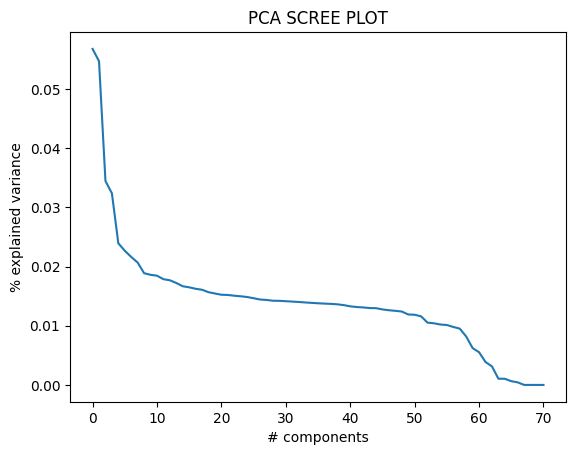

In [ ]:
plt.plot(var)
plt.xlabel('# components')
plt.ylabel('% explained variance')
plt.title('PCA SCREE PLOT')
plt.show()


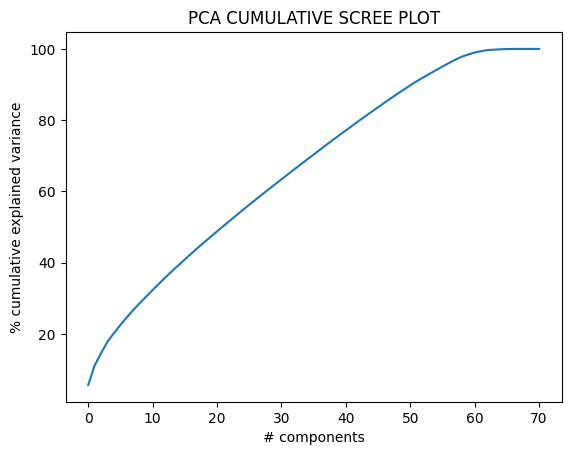

In [ ]:
plt.plot(np.cumsum(var)*100)
plt.xlabel('# components')
plt.ylabel('% cumulative explained variance')
plt.title('PCA CUMULATIVE SCREE PLOT')
plt.show()


In [ ]:
np.min(np.where(np.cumsum(var)>0.7))

35

# VALIDATION SPLIT

In [ ]:
np.random.seed(seed=123)
idx = np.random.choice(np.arange(0, len(train_resp)), size=int(0.8*len(train_resp)), replace=False)
idx2 = np.setdiff1d(np.arange(0, len(train_resp)), idx)

In [ ]:
val_cov = train_cov.iloc[idx2]
val_resp = train_resp.iloc[idx2]

train_cov = train_cov.iloc[idx]
train_resp = train_resp.iloc[idx]

# CLASSIFICATION

## Deep Learning

### Neural Network

In [ ]:
#Define the structure for the Deep Neural Network.
model = models.Sequential()

model.add(tf.keras.Input(shape=(71,)))
model.add(layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)))
model.add(layers.Dropout(0.4, seed=sd+1))
model.add(layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)))
model.add(layers.Dropout(0.4, seed=sd+2))
model.add(layers.Dense(32, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)))
model.add(layers.Dropout(0.4, seed=sd+3))
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
#Define the structure for the Deep Neural Network.
model2 = models.Sequential()

model2.add(tf.keras.Input(shape=(71,)))
model2.add(layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)))
model2.add(layers.Dropout(0.4, seed=sd+1))
model2.add(layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)))
model2.add(layers.Dropout(0.4, seed=sd+1))
model2.add(layers.Dense(512, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)))
model2.add(layers.Dropout(0.4, seed=sd+1))
model2.add(layers.Dense(1024, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)))
model2.add(layers.Dropout(0.4, seed=sd+1))
model2.add(layers.Dense(512, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)))
model2.add(layers.Dropout(0.4, seed=sd+1))
model2.add(layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)))
model2.add(layers.Dropout(0.4, seed=sd+1))
model2.add(layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)))
model2.add(layers.Dropout(0.4, seed=sd+1))
model2.add(layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)))
model2.add(layers.Dropout(0.4, seed=sd+2))
model2.add(layers.Dense(32, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)))
model2.add(layers.Dropout(0.4, seed=sd+3))
model2.add(layers.Dense(1, activation='sigmoid'))

#### Utils

In [ ]:
def plot_history(history):
  fig = make_subplots(rows = 1, cols = 2, subplot_titles = ["Loss", "Accuracy"])
  fig.add_trace(go.Scatter(y = history.history['val_loss'], name = "val_loss"), row = 1, col = 1,)
  fig.add_trace(go.Scatter(y = history.history['loss'], name = "loss"), row = 1, col = 1,)
  fig.add_trace(go.Scatter(y = history.history['val_accuracy'], name = "val accuracy"), row = 1, col = 2,)
  fig.add_trace(go.Scatter(y = history.history['accuracy'], name = "accuracy"), row = 1, col = 2,)
  # Set x-axis title
  fig.update_xaxes(title_text = "Epoch")
  # Set y-axes titles
  fig.update_yaxes(title_text = "Loss", row = 1, col = 1)
  fig.update_yaxes(title_text = "Accuracy", row = 1, col = 2)
  fig.show()

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

def plot_ROC(y_pred,y_test):
  fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred)
  auc_keras = auc(fpr_keras, tpr_keras)
  plt.plot(fpr_keras, tpr_keras)
  plt.xlabel('False positive rate')
  plt.ylabel('True positive rate')
  plt.title('ROC curve')
  plt.legend(loc='best')
  plt.show()
  return print('AUC:', auc_keras), print('Optimal Threshold - YoudenJ:', thresholds_keras[np.argmax(tpr_keras - fpr_keras)]), print('Optimal Threshold - Gmean:', thresholds_keras[np.argmax(np.sqrt(tpr_keras*(1- fpr_keras)))])

In [ ]:
import pickle

def save_pkl(filename, obj):
  with open(filename, 'wb') as f:
    pickle.dump(obj, f)

def load_pkl(filename):
  with open(filename, 'rb') as f:
    obj = pickle.load(f)
  return obj

In [ ]:
def compute(lista, tit):
  import numpy as np
  import matplotlib.pyplot as plt

  names=[]
  for name,true,pred in lista:
    true = np.array(true).flatten()
    pred = pred.flatten()

    # Calcola il numero totale di esempi positivi (true=1)
    total_positives = np.sum(true)

    # Ordina gli array pred e true in base ai valori di pred in ordine decrescente
    sorted_indices = np.argsort(pred)[::-1]
    sorted_pred = pred[sorted_indices]
    sorted_true = true[sorted_indices]

    # Calcola il numero di esempi positivi per ogni percentile
    percentiles = np.arange(1, 10)

    positive_counts = []
    c=True
    l=len(sorted_pred)
    n=len(percentiles)
    for percentile in percentiles:
      if c:
        left=0
        c=False
      else:
        left=right

      right = (l/n)*percentile

      selected_true = sorted_true[int(left):int(right)]
      positive_counts.append(np.sum(selected_true))

    # Calcola la percentuale di esempi positivi per ogni percentile
    positive_percentages = (np.array(positive_counts) / total_positives) * 100
    score = 0
    for j,sc in enumerate(positive_percentages):
      score = score + sc/(j+1)

    names.append(f"{name} (CDD: {round(score,1)})")
    # Crea il grafico
    plt.plot(percentiles, positive_percentages)
  plt.xlabel("Decili")
  plt.ylabel("% di churner contenuta")
  plt.title(tit)
  plt.legend(names)
  plt.grid(True)
  plt.show()


In [ ]:
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor = "val_loss",
        min_delta = 0,
        patience = 10,
        restore_best_weights = True
    )
]

### Original Train Data

In [ ]:
model.compile(optimizer='adam', loss=tf.keras.losses.binary_crossentropy, metrics=['accuracy'])
history = model.fit(train_cov, train_resp, validation_data=(val_cov, val_resp), epochs=100, batch_size=2000, callbacks = [callbacks])
pred_resp1 = model.predict(val_cov)

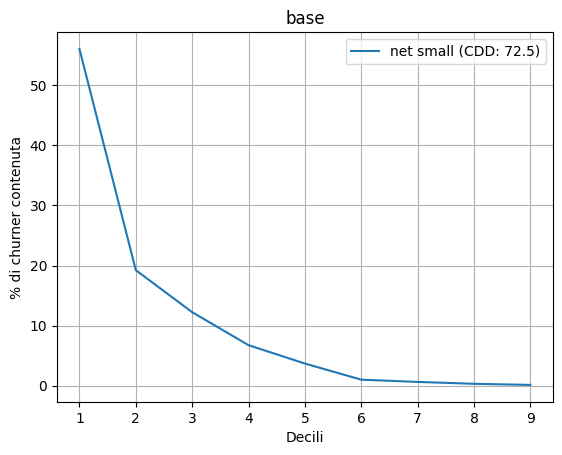

In [ ]:
compute([('net small',val_resp, pred_resp1)], "base")

In [ ]:
model2.compile(optimizer='adam', loss=tf.keras.losses.binary_crossentropy, metrics=['accuracy'])
history = model2.fit(train_cov, train_resp, validation_data=(val_cov, val_resp), epochs=100, batch_size=2000, callbacks = [callbacks])
pred_resp1s = model2.predict(val_cov)

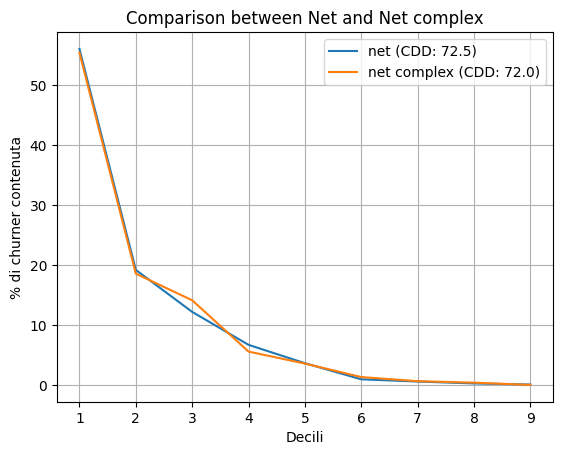

In [ ]:
compute([('net',val_resp, pred_resp1), ('net complex',val_resp, pred_resp1s)], "Comparison between Net and Net complex")

### Oversampling on Train Data

#### ROS

In [ ]:
#RANDOM
ros = RandomOverSampler(sampling_strategy=0.5, random_state=123)
train_cov_ros, train_resp_ros = ros.fit_resample(train_cov, train_resp)

In [ ]:
model.compile(optimizer='adam', loss=tf.keras.losses.binary_crossentropy, metrics=['accuracy'])

In [ ]:
history = model.fit(train_cov_ros, train_resp_ros, validation_data=(val_cov, val_resp), epochs=600, batch_size=2000, callbacks = [callbacks])

In [ ]:
pred_resp2 = model.predict(val_cov)

1653/1653 [==============================] - 5s 3ms/step


#### SMOTE

In [ ]:
#SMOTE
smote = SMOTE(sampling_strategy=0.5, random_state=123)
train_cov_smote, train_resp_smote= smote.fit_resample(train_cov, train_resp)

In [ ]:
model.compile(optimizer='adam', loss=tf.keras.losses.binary_crossentropy, metrics=['accuracy'])

In [ ]:
history = model.fit(train_cov_smote, train_resp_smote, validation_data=(val_cov, val_resp), epochs=200, batch_size=2000, callbacks = [callbacks])

Epoch 1/200
154/154 [==============================] - 2s 6ms/step - loss: 0.5474 - accuracy: 0.6667 - val_loss: 0.1988 - val_accuracy: 0.9697
Epoch 2/200
154/154 [==============================] - 1s 6ms/step - loss: 0.5222 - accuracy: 0.6667 - val_loss: 0.2087 - val_accuracy: 0.9697
Epoch 3/200
154/154 [==============================] - 1s 7ms/step - loss: 0.5005 - accuracy: 0.6667 - val_loss: 0.2106 - val_accuracy: 0.9697
Epoch 4/200
154/154 [==============================] - 1s 7ms/step - loss: 0.4820 - accuracy: 0.6667 - val_loss: 0.2190 - val_accuracy: 0.9697
Epoch 5/200
154/154 [==============================] - 1s 7ms/step - loss: 0.4655 - accuracy: 0.6667 - val_loss: 0.2274 - val_accuracy: 0.9697
Epoch 6/200
154/154 [==============================] - 1s 6ms/step - loss: 0.4511 - accuracy: 0.6667 - val_loss: 0.2232 - val_accuracy: 0.9697
Epoch 7/200
154/154 [==============================] - 1s 5ms/step - loss: 0.4382 - accuracy: 0.6667 - val_loss: 0.2385 - val_accuracy: 0.9697

In [ ]:
pred_resp3 = model.predict(val_cov)

1653/1653 [==============================] - 2s 1ms/step


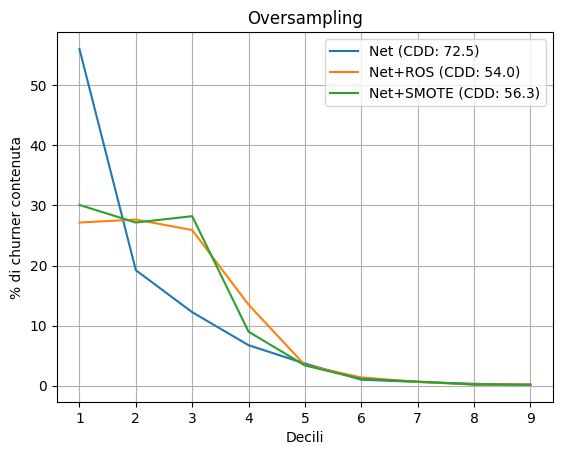

In [ ]:
compute([('Net',val_resp, pred_resp1),('Net+ROS',val_resp, pred_resp2),('Net+SMOTE',val_resp, pred_resp3)], "Oversampling")

### Undersampling on Train Data

#### RUS

In [ ]:
#RANDOM
rus = RandomUnderSampler(sampling_strategy = 0.5,random_state=123)
train_cov_rus, train_resp_rus= rus.fit_resample(train_cov, train_resp)

In [ ]:
model.compile(optimizer='adam', loss=tf.keras.losses.binary_crossentropy, metrics=['accuracy'])

In [ ]:
history = model.fit(train_cov_rus, train_resp_rus, validation_data=(val_cov, val_resp), epochs=200, batch_size=2000, callbacks = [callbacks])

Epoch 1/200
10/10 [==============================] - 2s 57ms/step - loss: 0.5528 - accuracy: 0.6667 - val_loss: 0.2144 - val_accuracy: 0.9697
Epoch 2/200
10/10 [==============================] - 0s 21ms/step - loss: 0.5510 - accuracy: 0.6667 - val_loss: 0.2099 - val_accuracy: 0.9697
Epoch 3/200
10/10 [==============================] - 0s 29ms/step - loss: 0.5481 - accuracy: 0.6667 - val_loss: 0.2122 - val_accuracy: 0.9697
Epoch 4/200
10/10 [==============================] - 0s 26ms/step - loss: 0.5462 - accuracy: 0.6667 - val_loss: 0.2099 - val_accuracy: 0.9697
Epoch 5/200
10/10 [==============================] - 0s 19ms/step - loss: 0.5445 - accuracy: 0.6667 - val_loss: 0.2160 - val_accuracy: 0.9697
Epoch 6/200
10/10 [==============================] - 0s 20ms/step - loss: 0.5438 - accuracy: 0.6667 - val_loss: 0.2095 - val_accuracy: 0.9697
Epoch 7/200
10/10 [==============================] - 0s 25ms/step - loss: 0.5420 - accuracy: 0.6667 - val_loss: 0.2176 - val_accuracy: 0.9697
Epoch 

In [ ]:
pred_resp4 = model.predict(val_cov)

1653/1653 [==============================] - 2s 1ms/step


#### NEAR MISS

In [ ]:
#NEARMISS
nearmiss = NearMiss(sampling_strategy = 0.5, version=1)
train_cov_nm, train_resp_nm= nearmiss.fit_resample(train_cov, train_resp)

In [ ]:
model.compile(optimizer='adam', loss=tf.keras.losses.binary_crossentropy, metrics=['accuracy'])

In [ ]:
history = model.fit(train_cov_nm, train_resp_nm, validation_data=(val_cov, val_resp), epochs=200, batch_size=2000, callbacks = [callbacks])

Epoch 1/200
10/10 [==============================] - 2s 36ms/step - loss: 0.5671 - accuracy: 0.6667 - val_loss: 0.2228 - val_accuracy: 0.9697
Epoch 2/200
10/10 [==============================] - 0s 15ms/step - loss: 0.5338 - accuracy: 0.6667 - val_loss: 0.2747 - val_accuracy: 0.9697
Epoch 3/200
10/10 [==============================] - 0s 23ms/step - loss: 0.5274 - accuracy: 0.6667 - val_loss: 0.2984 - val_accuracy: 0.9697
Epoch 4/200
10/10 [==============================] - 0s 22ms/step - loss: 0.5216 - accuracy: 0.6667 - val_loss: 0.2943 - val_accuracy: 0.9697
Epoch 5/200
10/10 [==============================] - 0s 14ms/step - loss: 0.5162 - accuracy: 0.6667 - val_loss: 0.3062 - val_accuracy: 0.9697
Epoch 6/200
10/10 [==============================] - 0s 13ms/step - loss: 0.5133 - accuracy: 0.6667 - val_loss: 0.2973 - val_accuracy: 0.9697
Epoch 7/200
10/10 [==============================] - 0s 14ms/step - loss: 0.5118 - accuracy: 0.6667 - val_loss: 0.3117 - val_accuracy: 0.9697
Epoch 

In [ ]:
pred_resp5 = model.predict(val_cov)

1653/1653 [==============================] - 2s 1ms/step


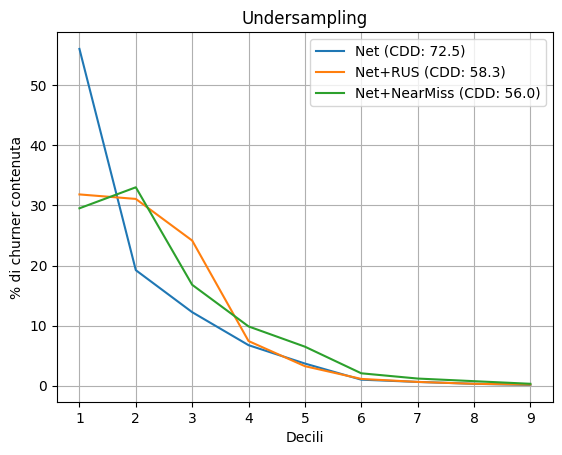

In [ ]:
compute([('Net',val_resp, pred_resp1),('Net+RUS',val_resp, pred_resp4),('Net+NearMiss',val_resp, pred_resp5)], "Undersampling")

## TREE-BASED METHODS

### RF

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

In [ ]:
clf = RandomForestClassifier(criterion='log_loss',
    max_depth=5, random_state=0, bootstrap=True, n_jobs=4,
    class_weight = {0:1, 1:4})
clf.fit(train_cov, train_resp)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RandomForestClassifier(class_weight={0: 1, 1: 4}, criterion='log_loss',
                       max_depth=5, n_jobs=4, random_state=0)

In [ ]:
pred_rf = clf.predict_proba(val_cov)[:,1]

### XGBOOST

In [ ]:
import xgboost

In [ ]:
clf = xgboost.XGBClassifier(n_estimators=100,
                                 learning_rate=0.1,
                                 max_depth=7,
                                 random_state=0,
                                 verbosity=1)

clf.fit(train_cov, train_resp)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=0, ...)

In [ ]:
pred_xgb = clf.predict_proba(val_cov)[:,1]

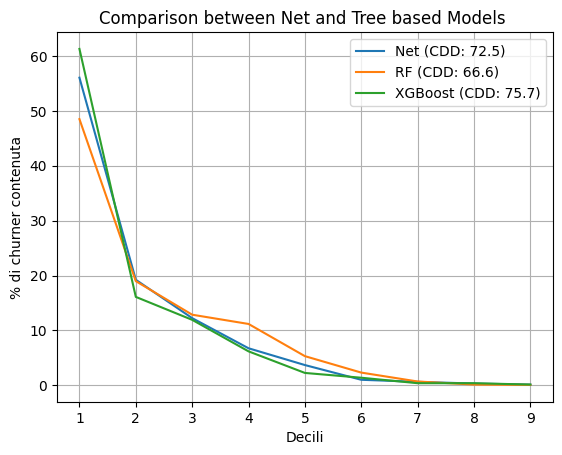

In [ ]:
compute([('Net',val_resp, pred_resp1),('RF',val_resp, pred_rf), ('XGBoost',val_resp, pred_xgb)], "Comparison between Net and Tree based Models ")

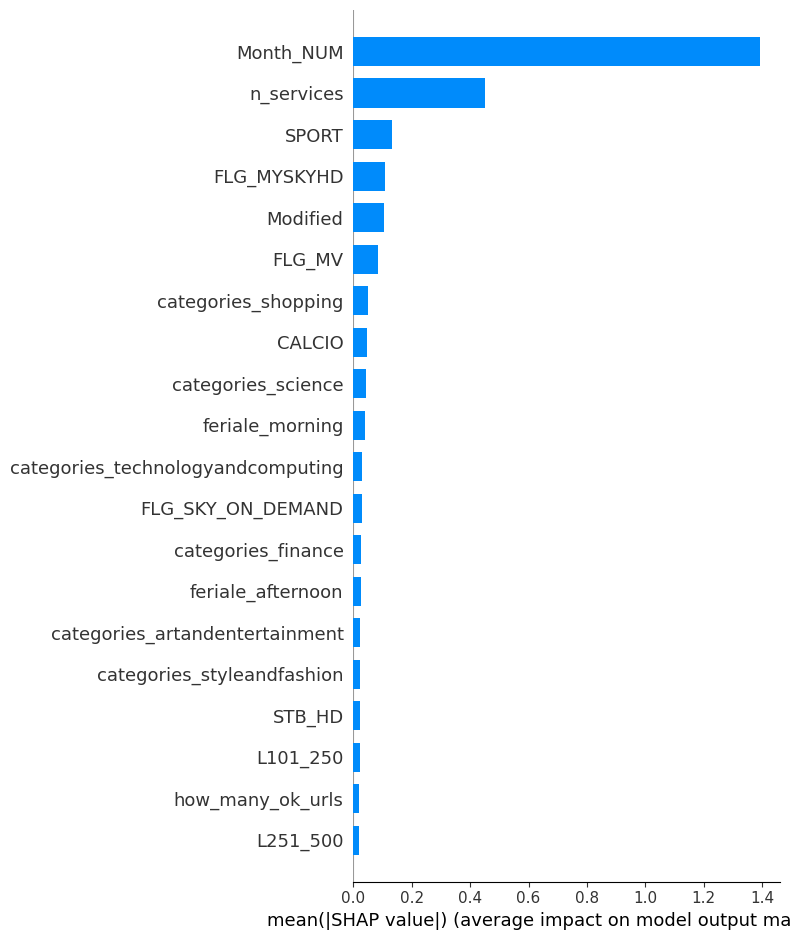

In [ ]:
# Creazione di un oggetto explainer utilizzando il modello XGBoost
explainer = shap.Explainer(clf)

# Calcolo degli SHAP values per i dati di test
shap_values = explainer.shap_values(val_cov)

# Visualizzazione delle spiegazioni
shap.summary_plot(shap_values, val_cov, plot_type="bar")

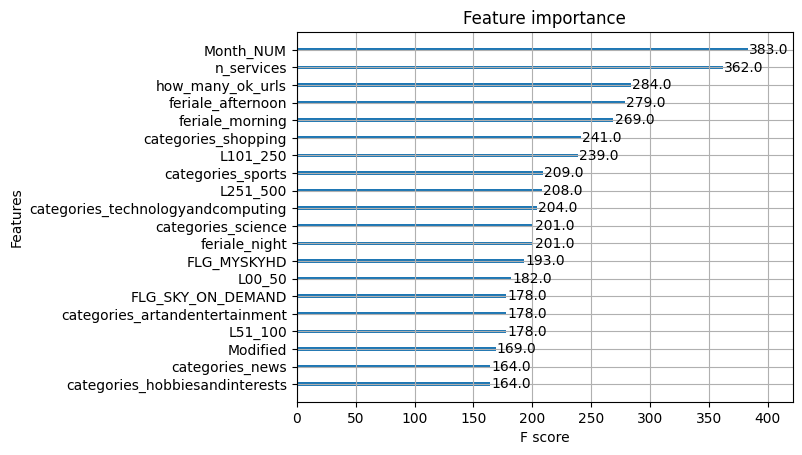

In [ ]:
import xgboost as xgb

xgb.plot_importance(clf, max_num_features=20)
plt.show()


# COST ANALYSIS

In [ ]:
net = clf.predict_proba(val_cov)

In [ ]:
def fn(t,p):
  c=0
  for j in range(len(t)):
    if (p[j]==0) and (t[j]==1):
      c=c+1

  return c/len(t)

def fp(t,p):
  c=0
  for j in range(len(t)):
    if (p[j]==1) and (t[j]==0):
      c=c+1

  return c/len(t)


def tn(t,p):
  c=0
  for j in range(len(t)):
    if (p[j]==0) and (t[j]==0):
      c=c+1

  return c/len(t)

def tp(t,p):
  c=0
  for j in range(len(t)):
    if (p[j]==1) and (t[j]==1):
      c=c+1

  return c/len(t)

In [ ]:
from sys import ps2
p1=[]
r1=[]
p2=[]
r2=[]
treshold=[]
for i in range(0,100,1):
  treshold.append(i/100)
  p1.append(fn(list(val_resp['Pdisc']), net[:,1]>i/100))
  r1.append(fp(list(val_resp['Pdisc']), net[:,1]>i/100))
  p2.append(tn(list(val_resp['Pdisc']), net[:,1]>i/100))
  r2.append(tp(list(val_resp['Pdisc']), net[:,1]>i/100))




In [ ]:
df = pd.DataFrame({'treshold': treshold, 'fn':p1, 'fp':r1, 'tn':p2, 'tp':r2})

In [ ]:
df['cost'] = df[['fn','fp','tn','tp']].apply(lambda x: 50*x[0] + 10*x[1] + 0*x[2] + 0*x[3], axis=1)


In [ ]:
df

,treshold,fn,fp,tn,tp,cost
0,0.00,0.000000,0.969712,0.000000,0.030288,9.697124
1,0.01,0.001305,0.423704,0.546008,0.028983,4.302271
2,0.02,0.002571,0.336963,0.632749,0.027716,3.498194
3,0.03,0.004764,0.254949,0.714764,0.025523,2.787703
4,0.04,0.007676,0.178474,0.791239,0.022612,2.168529
...,...,...,...,...,...,...
95,0.95,0.030288,0.000000,0.969712,0.000000,1.514378
96,0.96,0.030288,0.000000,0.969712,0.000000,1.514378
97,0.97,0.030288,0.000000,0.969712,0.000000,1.514378
98,0.98,0.030288,0.000000,0.969712,0.000000,1.514378


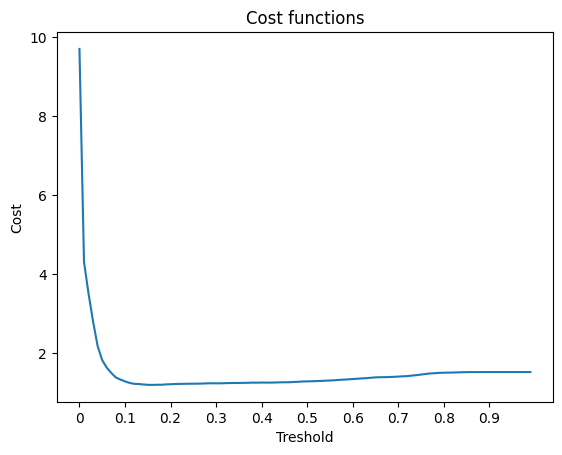

In [ ]:
fig, ax =  plt.subplots()
line1, = ax.plot(df['cost'])

ax.set_xlabel('Treshold')
ax.set_ylabel('Cost')
ax.set_title('Cost functions')
plt.xticks(range(0,100, 10), [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

plt.show()

In [ ]:
df.iloc[np.argmin(df['cost'])]

treshold    0.160000
fn          0.020891
fp          0.014388
tn          0.955325
tp          0.009396
cost        1.188437
Name: 16, dtype: float64

## RISPARMIO

In [ ]:
import random

In [ ]:
y = test_resp
y_hat = clf.predict_proba(test_cov)[:,1]

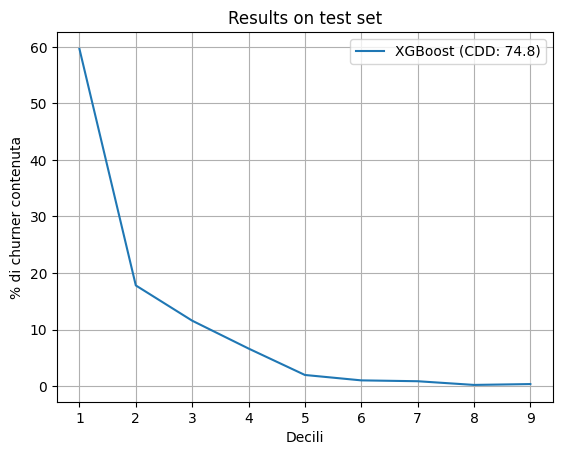

In [ ]:
compute([('XGBoost',y, y_hat)], "Results on test set")

In [ ]:
confusion_matrix(y, y_hat>0.16)

array([[63218,   911],
       [ 1386,   603]])

In [ ]:

fn=0
fp=0
tp=0
for i in range(1000):
  random_pred = [0 if random.random()>0.03 else 1 for i in range(66118)]
  fp = fp + confusion_matrix(test_resp, random_pred)[0,1]
  fn = fn + confusion_matrix(test_resp, random_pred)[1,0]
  tp = tp + confusion_matrix(test_resp, random_pred)[1,1]

fp = fp/1000
fn = fn/1000
tp = tp/1000

print(f'FP: {fp} FN: {fn} TP: {tp}')

FP: 1925.265 FN: 1929.648 TP: 59.352


In [ ]:
# RANDOM
fp*10 + fn*50 + tp* (0.7*10 + 0.3*60)

117218.84999999999

In [ ]:
# XGBOOST
911*10 + 1386*50 + 603*(0.7*10 + 0.3*60)

93485.0

In [ ]:
print(f"-{round(100*(117218 - 93485.0) / 117218, 2)}%")

-20.25%
